In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([45., 26., 12.,  7.,  2.,  5.,  1.,  1.,  0.,  1.]),
 array([ 1.11648467,  3.72460444,  6.33272421,  8.94084398, 11.54896375,
        14.15708351, 16.76520328, 19.37332305, 21.98144282, 24.58956259,
        27.19768236]),
 <a list of 10 Patch objects>)

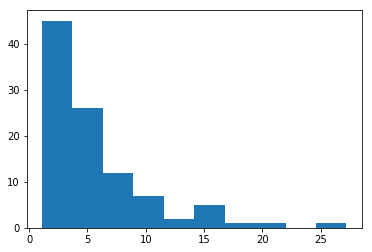

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([1407.42378388,  299.70633843,  396.65230579,  196.14249301,
         884.93325747, 1231.90821217,  366.91940531, 2976.31457906,
        2370.34004907,  373.46902895, 2100.52356084, 1514.72741308,
         969.48657293,  244.67933185, 2069.81198675,  807.56359911,
        3913.77867022,  477.24540118,  425.2796218 ,  197.14533499,
         366.66046245,  287.84548607,  962.32469305,  596.37999786,
         263.58238395, 3393.38543714,  104.84359812,  811.56647004,
         153.13817995, 2251.17724302,  515.7237366 , 2894.24898273,
        1231.46651969, 1415.16971825, 2337.36621312,  146.83680664,
        1140.38093187,  314.11308528, 2390.71283642, 2521.96223974,
         904.60687324,  413.47723723,  473.24221748,  662.88195157,
         694.85996477,  375.8844283 ,  124.05542311, 2110.10906034,
         364.15418736, 3764.39369716,  940.74027548, 1194.02810593,
         390.38987795,  119.13425397, 2548.86508288,  331.66034262,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.07755925, 2.24470557, 2.4098302 , 2.02902186, 2.80570956,
       2.49616081, 1.75242024, 2.49289777, 1.49761171, 2.81418327,
       2.17065121, 1.6230287 , 1.43368971, 2.01738904, 1.85588634,
       1.4431121 , 2.21520935, 2.32189953, 1.78084952, 2.38324342,
       1.98370785, 2.15841318, 1.58223243, 2.83679963, 2.23573104,
       1.80589055, 2.32730994, 1.47062394, 2.27068148, 1.32681134,
       1.42224261, 1.34642174, 1.32988017, 2.46422793, 1.99920026,
       2.06359389, 1.03247482, 2.30694027, 1.04475536, 1.57700623,
       2.45191579, 2.27733145, 2.07448679, 1.57554551, 1.73402343,
       2.33463815, 2.00381026, 1.80155308, 1.80902048, 2.55462204,
       1.10636809, 1.99089476, 2.73747909, 1.79471381, 2.14407607,
       1.58658515, 1.22312976, 1.75150796, 1.52203317, 0.65295242,
       2.32166091, 2.31925037, 1.93044075, 2.36307172, 1.68502226,
       2.19937172, 2.17623803, 2.62521808, 1.98566936, 1

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1d7c54a8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1d7c54a8>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

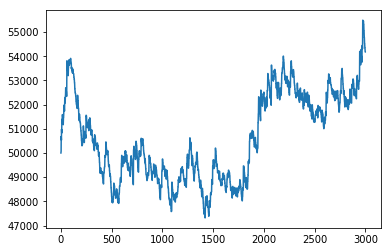

In [21]:
df.funds.plot()

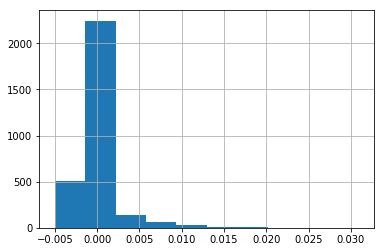

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

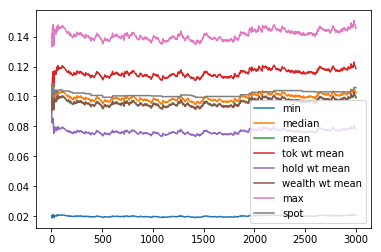

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

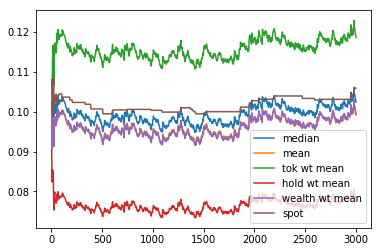

In [29]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

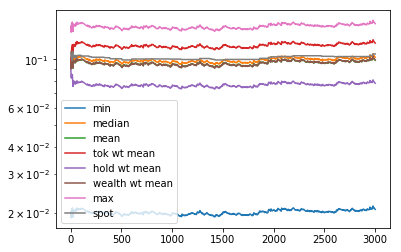

In [30]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [31]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

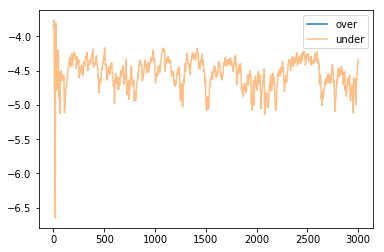

In [32]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [33]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

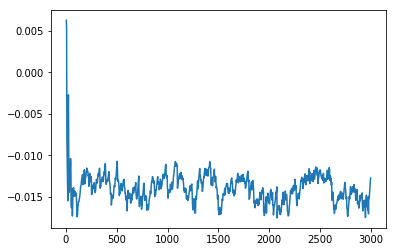

In [34]:
rdf.est_err.plot()

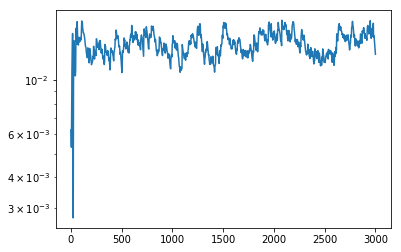

In [35]:
rdf.est_err.apply(np.abs).plot(logy=True)

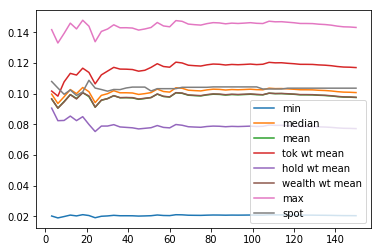

In [36]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

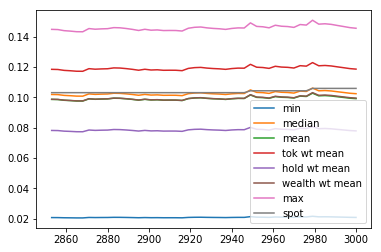

In [37]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [38]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [39]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [40]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [41]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [42]:
tx_summary

pbar                  amt
              median  count        median
agent mech                               
0     burn  0.097280    1.0  1.213036e+04
1     bond  0.098440    1.0  2.997063e+02
2     bond  0.108184    1.0  3.966523e+02
3     bond  0.102350    8.0  4.907633e-10
      burn  0.103033   35.0  1.006300e-09
4     bond  0.102364    1.0  8.849333e+02
5     bond  0.102270    1.0  1.231908e+03
6     burn  0.101557    1.0  7.292577e+03
7     bond  0.104592    1.0  2.976315e+03
8     burn  0.095315    1.0  1.369188e+04
9     bond  0.098925    1.0  3.734690e+02
10    bond  0.104201    2.0  1.050262e+03
      burn  0.101930    1.0  2.915944e-09
11    burn  0.094379    1.0  1.220463e+04
12    burn  0.093262    1.0  8.434963e+03
13    bond  0.100753   36.0  5.633410e-10
      burn  0.100398  737.0  7.772904e-10
14    burn  0.095701    1.0  5.724260e+03
15    burn  0.096343    1.0  2.700423e+04
16    bond  0.105294    1.0  3.913779e+03
17    bond  0.101469    1.0  4.772454e+02
18    burn  0.100850    1.0  6.542538e+03
19    bond  0.110949    1.0  1.971453e+02
20    bond  0.101868    7.0  4.875830e+02
      burn  0.100854  499.0  1.459177e-09
21    bond  0.105397    2.0  1.439227e+02
      burn  0.103701    1.0  1.533058e-09
22    burn  0.097898    1.0  1.335085e+04
23    bond  0.103776    1.0  5.963800e+02
24    bond  0.104340    1.0  2.635824e+02
...              ...    ...           ...
78    bond  0.104059    1.0  5.939427e+02
      burn  0.106646    1.0  2.074052e-09
79    bond  0.106117    1.0  2.170078e+02
80    bond  0.103381    1.0  2.223600e+02
81    burn  0.096914    1.0  6.931094e+03
82    bond  0.102154    2.0  9.914086e+02
      burn  0.100035   31.0  2.280208e-09
83    burn  0.096588    1.0  7.750186e+03
84    burn  0.097687    1.0  1.581040e+04
85    bond  0.100963    1.0  1.752490e+03
86    bond  0.103238    1.0  1.105773e+03
      burn  0.107730    1.0  2.117344e-09
87    bond  0.105481    1.0  1.135542e+03
88    burn  0.100319    1.0  8.412830e+03
89    burn  0.095648    1.0  1.182710e+04
90    bond  0.100772    1.0  9.309016e+02
      burn  0.102112    2.0  1.258986e+04
91    burn  0.099567    1.0  1.588342e+04
92    burn  0.095442    1.0  7.408984e+03
93    bond  0.103359    1.0  5.765758e+02
      burn  0.103483    6.0  1.918647e-09
94    bond  0.102403    2.0  8.326260e+02
      burn  0.101228    1.0  2.526479e-09
95    bond  0.100937   36.0  3.248715e-10
      burn  0.104319  285.0  6.626013e-10
96    bond  0.104103    1.0  9.669789e+02
97    bond  0.104439    1.0  1.364037e+03
98    bond  0.101628    2.0  9.932041e+02
      burn  0.105200    1.0  6.014343e+03
99    burn  0.102819    1.0  7.137663e+03

[125 rows x 3 columns]

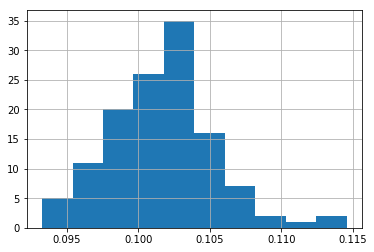

In [43]:
tx_summary.pbar['median'].hist()

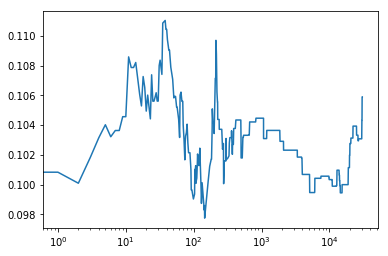

In [44]:
sdf['P'].plot(logx=True)

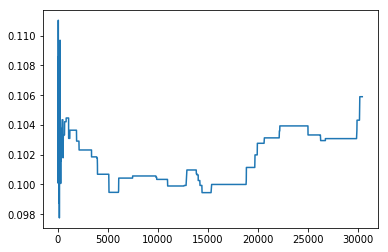

In [45]:
sdf['P'].plot()

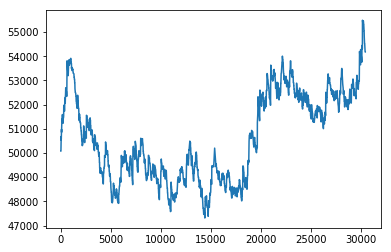

In [46]:
sdf.F.plot()

In [47]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

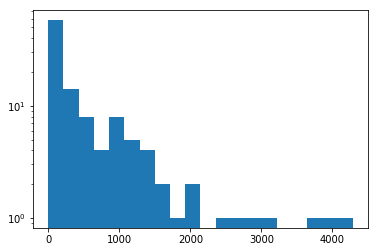

In [48]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

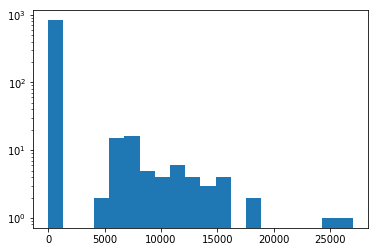

In [49]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [50]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

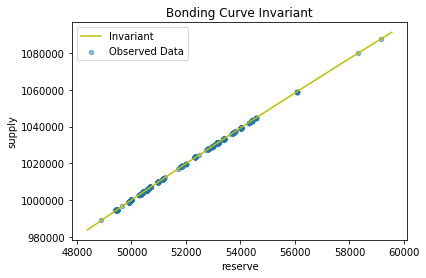

In [51]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [52]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([52., 12.,  8., 13.,  7.,  2.,  4.,  1.,  0.,  1.]),
 array([   0.        ,  579.18717261, 1158.37434522, 1737.56151782,
        2316.74869043, 2895.93586304, 3475.12303565, 4054.31020825,
        4633.49738086, 5212.68455347, 5791.87172608]),
 <a list of 10 Patch objects>)

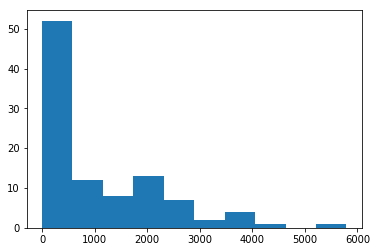

In [53]:
plt.hist(rdf.iloc[-1].holdings)

In [54]:
rdf['gini_h'] = rdf.holdings.apply(gini)

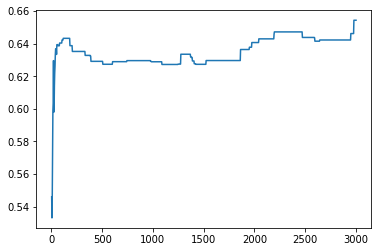

In [55]:
rdf.gini_h.plot()

(array([45., 12., 14.,  7.,  8.,  5.,  3.,  2.,  1.,  3.]),
 array([    0.        ,  4991.14017414,  9982.28034827, 14973.42052241,
        19964.56069655, 24955.70087068, 29946.84104482, 34937.98121896,
        39929.12139309, 44920.26156723, 49911.40174136]),
 <a list of 10 Patch objects>)

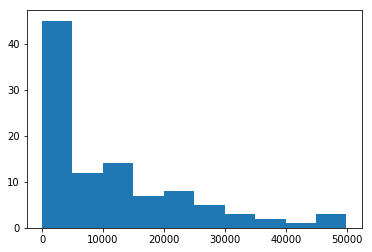

In [56]:
plt.hist(rdf.iloc[-1].tokens)

In [57]:
rdf['gini_s'] = rdf.tokens.apply(gini)

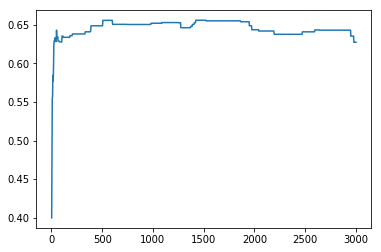

In [58]:
rdf.gini_s.plot()

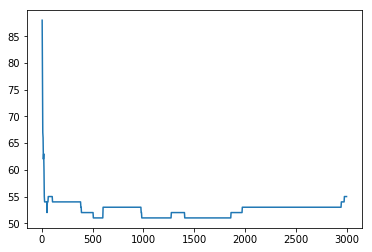

In [59]:
rdf.tokens.apply(np.count_nonzero).plot()

In [60]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([29., 15., 17., 14.,  8.,  8.,  3.,  2.,  2.,  2.]),
 array([ 686.08043782, 1196.65956664, 1707.23869547, 2217.81782429,
        2728.39695312, 3238.97608195, 3749.55521077, 4260.1343396 ,
        4770.71346842, 5281.29259725, 5791.87172608]),
 <a list of 10 Patch objects>)

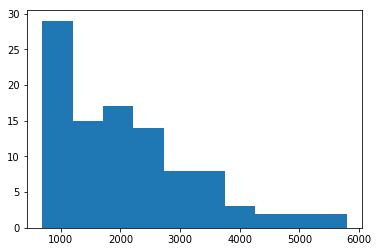

In [61]:
plt.hist(rdf.iloc[-1].asset_value)

In [62]:
rdf['gini'] = rdf.asset_value.apply(gini)

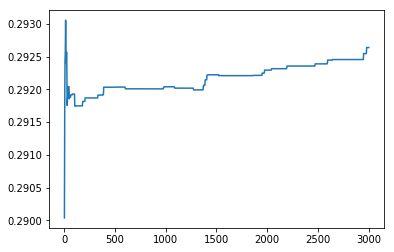

In [63]:
rdf.gini.plot()

In [64]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 2.,  4., 10., 22., 22., 30., 10.]),
  array([ 2.,  4.,  9., 23., 22., 30., 10.]),
  array([ 2.,  4., 10., 23., 22., 30.,  9.]),
  array([ 2.,  4., 10., 24., 22., 30.,  8.]),
  array([ 2.,  5., 10., 25., 21., 29.,  8.]),
  array([ 2.,  5., 10., 25., 23., 27.,  8.]),
  array([ 2.,  5., 11., 24., 24., 26.,  8.])],
 array([-0.80437477, -0.63190418, -0.4594336 , -0.28696302, -0.11449244,
         0.05797815,  0.23044873,  0.40291931]),
 <a list of 7 Lists of Patches objects>)

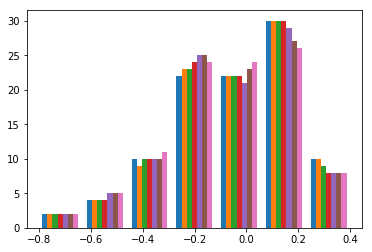

In [65]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)